In [1]:
import torch
import math
#from dlc_practical_prologue import *
#torch.set_grad_enabled(False)

In [2]:
#INTERESTING FACT: WHEN COMPUTING THE BATCH GRADIENT PYTORCH DOES NOT TAKE THE SUM OF THE GRADIENTA OF SINGLE DATA POINTS
#BUT THE MEAN. I LEART AT THE EXPENSE OF ABOUT 1H LOL 

In [3]:
class Parameter():
    def __init__(self):
        self.name = ''
        self.data = None
        self.grad = None

In [4]:
class Module(object):
    def forward (self, *input):
        raise NotImplementedError
        
    def backward ( self , * gradwrtoutput ) :
        raise NotImplementedError
    
    def get_parameters( self ) :
        return []   

In [5]:
class Losses(object):        
    def forward():
        return NotImplementedError
    def backward():
        NotImplementedError

In [6]:
class Optimizer(object):
    def zero_grad(self):
        for parameter in self.param : 
            parameter.grad = 0
            
    def step(self):
        raise NotImplementedError

In [7]:
class SGD(Optimizer):
    # this is a SGD optimizer
    def __init__(self,lr,max_iter, parameters) :  
        super().__init__()
        self.eta = lr
        self.maxStep = max_iter 
        self.param = parameters
        self.number_step = 0

    def step(self): 
        if self.number_step <=self.maxStep:
            for parameter in self.param :
                parameter.data = parameter.data - self.eta * parameter.grad
            self.number_step = self.number_step + 1
        return self.param

In [8]:
class Linear(Module):
    
    def __init__(self, input_dim, out_dim, bias = True):
        super().__init__()
        std = 1/math.sqrt(input_dim)
        self.weight = Parameter()
        self.parameters = []
        
        self.weight.data = torch.rand(out_dim, input_dim)
        self.weight.data = 2*std*self.weight.data - std
        self.weight.name = 'weight'
        self.parameters += [self.weight]
        
        self.with_bias = bias
        if bias :
            self.bias = Parameter()
            self.bias.data = torch.rand(out_dim)
            self.bias.data = 2*std*self.bias.data - std
            self.bias.data = self.bias.data.unsqueeze(0)
            self.bias.name = 'bias'
            self.parameters +=[self.bias]
            
        self.x = None
              
    def forward(self, x):
        self.x = x
        self.batch_size = x.shape[0]
        return self.x.mm(self.weight.data.T) + self.bias.data
        
    def backward(self, prev_grad):
        
        prev_grad = prev_grad.view(self.batch_size, -1, 1)
        #print(prev_grad.shape)
        if self.x is None:
            raise CallForwardFirst
        
        if self.weight.grad is None:
            self.weight.grad = torch.zeros_like(self.weight.data)
        
        grad_on_batch = prev_grad.view(self.batch_size, -1, 1)*self.x.view(self.batch_size, 1, -1)
        self.weight.grad += grad_on_batch.mean(0)
        
        if self.with_bias:
            if self.bias.grad is None:
                self.bias.grad = torch.zeros_like(self.bias.data)
            grad_on_batch = prev_grad.view(self.batch_size, -1)
            self.bias.grad += grad_on_batch.mean(0)
        
        #if the output has dimension one, squeezing creates problems
        if prev_grad.shape[1]>1:
            prev_grad = prev_grad.squeeze()
        next_grad = prev_grad@self.weight.data
        return next_grad.squeeze()
    
    def get_parameters(self):
        return self.parameters    

In [9]:
class Tanh(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.tanh(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)
        
        return d(self.x)*prev_grad
            

In [10]:
class ReLu(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        x[x<0]=0
        return x
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            x[x<0]=0
            x[x>0]=1
            return x
        
        return d(self.x)*prev_grad
            

In [11]:
#Doesn't work and we have to output 1 unit so it's useless
class Softmax(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.softmax(x,1)     
     
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        
        def d(x):
            s = x.softmax(1)
            temp = s.unsqueeze(-1)
            off_diag = temp*torch.transpose(temp, 1, 2)
            diag = torch.diag_embed(torch.diagonal(off_diag, dim1 = 1, dim2 = 2).sqrt()) 
            return diag - off_diag
        return torch.einsum('b ij, bj -> bi', d(self.x),prev_grad)/ x.shape[0]

In [12]:
#Doesn't work and we have to output 1 unit so it's useless
class Sigmoid(Module):
    def __init__(self):
        self.x = None
    
    def forward (self, x):
        self.x = x
        return torch.sigmoid(x)
        
    def backward ( self, prev_grad) :
        if self.x is None:
            raise CallForwardFirst
            
        def d(x):
            y=torch.sigmoid(x)
            return y*(1-y)
        
        return d(self.x)*prev_grad

In [13]:
class MSE(Losses):
    # Attention! Works well only when the vectors provided are of the form [batch_size, vector dimension]
    # Otherwise it doesn know what dimesion to pick for the mean computation
    # I'll fix this later
    def __init__(self):
        self.x = None
    def forward(self, x, t):
        self.x = x
        self.t = t
        return (x - t).pow(2).mean()
    
    def backward(self):
        if self.x == None or self.t == None:
            raise CallForwardFirst
        return 2 * (self.x - self.t)/(self.x.shape[1]*self.x.shape[0])

In [14]:
class Sequential(object):
    def __init__(self, modules):
        super().__init__()
        self.modules=modules
        self.parameters = []
        for m in self.modules:
            param = m.get_parameters()
            if param:
                self.parameters += param
        
    def forward(self,x):
        for m in self.modules:
            x=m.forward(x)
        return x
    
    def backward(self, loss_grad):
        x = loss_grad
        for m in reversed(self.modules):
            #print(m)
            x = m.backward(x)
            
    def get_parameters(self):
        return self.parameters

    def set_parameters(self , params):
        self.parameters = params
        

In [15]:
############################################################################################################################
################################# CHECK ON SOFTMAX ########################################################################

In [16]:
#check on the fradient od softmax
x = torch.randn(2, 5, requires_grad = True)

def d( x):
    s = x.softmax(1)
    temp = s.unsqueeze(-1)
    off_diag = temp*torch.transpose(temp, 1, 2)
    diag = torch.diag_embed(torch.diagonal(off_diag, dim1 = 1, dim2 = 2).sqrt()) 
    return diag - off_diag   


soft = Softmax()
s_b = x.softmax(1)
s_h = soft.forward(x.clone())
print('check on the values: builtin\n', s_b ,'\n homemade \n', s_h, '\n diff:\n', abs(s_b-s_h) )

selector = 0 #to make the check on one of the tensor in the batches

soft.backward(torch.ones(2, 5))
builtin_soft_der = torch.ones(1, 5)
for i in range(5):
    new = torch.autograd.grad(s_b[selector,i], x, retain_graph = True)[0][selector].unsqueeze(0)
    builtin_soft_der = torch.cat((builtin_soft_der, new), 0 )
builtin_soft_der = builtin_soft_der[1:]
print('builtin derivative on the selected tensor \n', builtin_soft_der)
print('homemade derivative on the whole batch \n', d(x))
print('difference on the selected tensor \n', abs(builtin_soft_der - d(x)[selector].unsqueeze(0)))

check on the values: builtin
 tensor([[0.0289, 0.1589, 0.2365, 0.0953, 0.4803],
        [0.0628, 0.2000, 0.2376, 0.4275, 0.0721]], grad_fn=<SoftmaxBackward>) 
 homemade 
 tensor([[0.0289, 0.1589, 0.2365, 0.0953, 0.4803],
        [0.0628, 0.2000, 0.2376, 0.4275, 0.0721]], grad_fn=<SoftmaxBackward>) 
 diff:
 tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<AbsBackward>)
builtin derivative on the selected tensor 
 tensor([[ 0.0281, -0.0046, -0.0068, -0.0028, -0.0139],
        [-0.0046,  0.1337, -0.0376, -0.0151, -0.0763],
        [-0.0068, -0.0376,  0.1806, -0.0225, -0.1136],
        [-0.0028, -0.0151, -0.0225,  0.0862, -0.0458],
        [-0.0139, -0.0763, -0.1136, -0.0458,  0.2496]])
homemade derivative on the whole batch 
 tensor([[[ 0.0281, -0.0046, -0.0068, -0.0028, -0.0139],
         [-0.0046,  0.1337, -0.0376, -0.0151, -0.0763],
         [-0.0068, -0.0376,  0.1806, -0.0225, -0.1136],
         [-0.0028, -0.0151, -0.0225,  0.0862, -0.0458],
         [-0.0139, -0.0

In [17]:
#check on the overall structure
loss_h = MSE()
loss_b = torch.nn.MSELoss()
soft = Softmax()

x = torch.randn(3, 5, requires_grad = True)
a = x.detach().clone()
a.requires_grad_(False)
y = torch.randn(3, 5)

l_b = loss_b(x.softmax(1), y)
l_b.backward()

output = soft.forward(a)
l_h = loss_h.forward(output, y)

x.grad, soft.backward(loss_h.backward())/3, abs(x.grad -  soft.backward(loss_h.backward())).max()

(tensor([[ 0.0001,  0.0108,  0.0235, -0.0048, -0.0296],
         [-0.0112,  0.0015,  0.0749, -0.0388, -0.0264],
         [-0.0240, -0.0234,  0.0932, -0.0164, -0.0294]]),
 tensor([[ 1.3317e-05,  1.2052e-03,  2.6071e-03, -5.3128e-04, -3.2944e-03],
         [-1.2453e-03,  1.6565e-04,  8.3227e-03, -4.3147e-03, -2.9283e-03],
         [-2.6632e-03, -2.6005e-03,  1.0352e-02, -1.8251e-03, -3.2629e-03]]),
 tensor(0.0621))

In [18]:
loss_h = MSE()
loss_b = torch.nn.MSELoss()
soft = Softmax()


x = torch.randn(6, 5, requires_grad = True)
a = x.detach().clone()
a.requires_grad_(False)
y = torch.randn(6, 5)


l_b = loss_b(x, y)
l_b.backward()

l_h = loss_h.forward(a, y)

x.grad, loss_h.backward(), abs(x.grad - loss_h.backward()).max()

(tensor([[ 0.0635, -0.0636,  0.0401, -0.1910,  0.0106],
         [-0.0721,  0.0626, -0.0669, -0.1009, -0.0910],
         [-0.0317, -0.0624, -0.0258,  0.0795,  0.1027],
         [-0.0311,  0.0351, -0.1353, -0.1580, -0.0202],
         [-0.0413,  0.0076,  0.0081, -0.0077, -0.0670],
         [-0.1032,  0.0999,  0.0197, -0.1707, -0.0668]]),
 tensor([[ 0.0635, -0.0636,  0.0401, -0.1910,  0.0106],
         [-0.0721,  0.0626, -0.0669, -0.1009, -0.0910],
         [-0.0317, -0.0624, -0.0258,  0.0795,  0.1027],
         [-0.0311,  0.0351, -0.1353, -0.1580, -0.0202],
         [-0.0413,  0.0076,  0.0081, -0.0077, -0.0670],
         [-0.1032,  0.0999,  0.0197, -0.1707, -0.0668]]),
 tensor(1.4901e-08))

In [19]:
#########################################################################################################################################################
############################################################################################################################

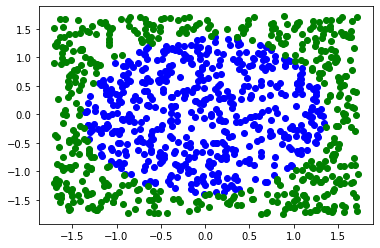

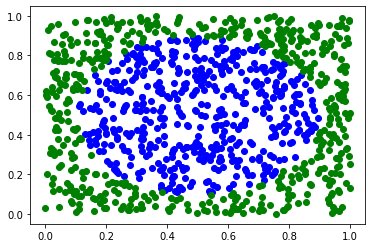

In [21]:
def generate_disc_set(nb):
    input_ = torch.rand(nb, 2)
    target = (input_-0.5).pow(2).sum(1).sub(1 / (math.pi*2)).sign().add(1).div(2).long()
    return input_, target
train_data, train_target= generate_disc_set(1000)
test_data,  test_target = generate_disc_set(1000)

train_target= 1 - train_target
test_target = 1 - test_target

#
train_data-=train_data.mean(0)
train_data/=train_data.std(0)

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
plt.plot(train_data[:,0][train_target==1], train_data[:,1][train_target==1],'bo')
plt.plot(train_data[:,0][train_target!=1], train_data[:,1][train_target!=1],'go')

fig = plt.figure()
plt.plot(test_data[:,0][test_target==1], test_data[:,1][test_target==1],'bo')
plt.plot(test_data[:,0][test_target!=1], test_data[:,1][test_target!=1],'go')

In [24]:
#output_data = 2*output_data -1
print(train_data, train_data.shape, test_data.shape)

tensor([[ 1.2971, -0.2548],
        [ 1.5493, -1.5915],
        [ 0.6331,  0.5892],
        ...,
        [ 1.2054, -0.0543],
        [ 0.3802,  0.9569],
        [-0.1571,  0.8939]]) torch.Size([1000, 2]) torch.Size([1000, 2])


In [ ]:
#we should use one hot label embedding with MSELoss. Hence it is necessary to implement a Softmax
#Maybe we should also implement CrossEntropyLoss
#print(input_data.shape, output_data.shape)
#output_data = convert_to_one_hot_labels(input_data, output_data)
#print(input_data.shape, output_data.shape)

In [25]:
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [29]:
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for i in range(N):
        x=train_data_shuffled[i]
        y=2*train_target_shuffled[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        net.backward(loss.backward())

    new_par = optimizer.step()
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  1032.6058349609375
10    MSE loss =  959.4874877929688
20    MSE loss =  912.4338989257812
30    MSE loss =  855.631591796875
40    MSE loss =  784.1046752929688
50    MSE loss =  697.8001098632812
60    MSE loss =  604.2974853515625
70    MSE loss =  515.4100952148438
80    MSE loss =  439.7731628417969
90    MSE loss =  379.906005859375


In [30]:
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = bool(y_pred.sign()*y)
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

Correct predictions after 100 training steps: 100.0 %


In [31]:
#Reinitialize net
#handmade sequential linear + relu 
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = Tanh()
sigma2 = Tanh()
sigma3 = Tanh()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])

In [34]:
optimizer = SGD(lr = 1e-1,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(train_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions, train_target_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())

0    MSE loss =  8.242544174194336
1    MSE loss =  7.605741024017334
2    MSE loss =  7.016584396362305
3    MSE loss =  6.476836681365967
4    MSE loss =  5.987658500671387
5    MSE loss =  5.547861099243164
6    MSE loss =  5.155143737792969
7    MSE loss =  4.806588172912598
8    MSE loss =  4.499165058135986
9    MSE loss =  4.2283735275268555
10    MSE loss =  4.071170806884766
11    MSE loss =  4.068775653839111
12    MSE loss =  4.068775653839111
13    MSE loss =  4.068775177001953
14    MSE loss =  4.068775653839111
15    MSE loss =  4.068775177001953
16    MSE loss =  4.068775177001953
17    MSE loss =  4.068775653839111
18    MSE loss =  4.068775177001953
19    MSE loss =  4.068775177001953
20    MSE loss =  4.068775177001953
21    MSE loss =  4.068775177001953
22    MSE loss =  4.068775653839111
23    MSE loss =  4.068775177001953
24    MSE loss =  4.068775177001953
25    MSE loss =  4.068775177001953
26    MSE loss =  4.068775177001953
27    MSE loss =  4.068775177001953
2

In [35]:
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = bool(y_pred.sign()*y)
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

Correct predictions after 100 training steps: 100.0 %


In [40]:
#handmade sequential linear + relu with sigmoid to end and no batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-4,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
for t in range(n):
    optimizer.zero_grad()
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for i in range(N):
        x=train_data_shuffled[i]
        y=train_target_shuffled[i]
        
        y_pred = net.forward(x.unsqueeze(0))
        
        acc_loss += loss.forward(y_pred,y.unsqueeze(0))
        
        net.backward(loss.backward())

    # Calling the step function on an Optimizer makes an update to its parameters
    new_par = optimizer.step()
    #print(len(new_par))
    net.set_parameters(new_par)
    
    
    if t%10==0:
        print(t, '   MSE loss = ' , acc_loss.item())
    
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = bool(y_pred.sign()*y)
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

0    MSE loss =  253.16091918945312
10    MSE loss =  249.6300506591797
20    MSE loss =  246.9554901123047
30    MSE loss =  244.79515075683594
40    MSE loss =  242.86146545410156
50    MSE loss =  241.04270935058594
60    MSE loss =  239.2564697265625
70    MSE loss =  237.47251892089844
80    MSE loss =  235.62258911132812
90    MSE loss =  233.69845581054688
Correct predictions after 100 training steps: 100.0 %


In [39]:
#handmade sequential linear + relu with softmax with batches
linear1 = Linear(2, 25, True)
linear2 = Linear(25,25,True)
linear3 = Linear(25,1,True)
sigma1 = ReLu()
sigma2 = ReLu()
sigma3 = Sigmoid()
loss = MSE()

net = Sequential([
    linear1, 
    sigma1 ,
    linear2,
    sigma2 ,
    linear3,
    sigma3 ,
])
optimizer = SGD(lr = 1e-1,max_iter = 100, parameters = net.get_parameters())
n=10**2
N=train_data.shape[0]
batch_size = 100
for t in range(n):
    acc_loss=0
    permuted_index = torch.randperm(train_data.size()[0])
    train_data_shuffled = train_data[permuted_index]
    train_target_shuffled = train_target[permuted_index]
    for b in range(0, N, batch_size):
        predictions = net.forward(train_data_shuffled[b:b+batch_size])
        l= loss.forward(predictions,train_target_shuffled[b:b+batch_size].unsqueeze(-1))
        acc_loss += l
        optimizer.zero_grad()
        
        net.backward(loss.backward())
        
        new_par = optimizer.step()
        net.set_parameters(new_par)
    
    print(t, '   MSE loss = ' , acc_loss.item())
    
#counting corrects on test
correct_count=0
for i in range(test_data.shape[0]):
        x=test_data[i]
        y=2*test_target[i]-1
        
        y_pred = net.forward(x.unsqueeze(0))
        
        correct = bool(y_pred.sign()*y)
        #print(y_pred.sign(), y, correct)
        if correct : correct_count += 1
            
print('Correct predictions after '+str(n)+' training steps: '+str(correct_count/N*100)+' %')

0    MSE loss =  2.5091164112091064
1    MSE loss =  2.5084969997406006
2    MSE loss =  2.5078909397125244
3    MSE loss =  2.5072715282440186
4    MSE loss =  2.506666660308838
5    MSE loss =  2.506060838699341
6    MSE loss =  2.505472183227539
7    MSE loss =  2.5048725605010986
8    MSE loss =  2.5042688846588135
9    MSE loss =  2.503674268722534
10    MSE loss =  2.5033156871795654
11    MSE loss =  2.5033133029937744
12    MSE loss =  2.5033130645751953
13    MSE loss =  2.5033135414123535
14    MSE loss =  2.5033130645751953
15    MSE loss =  2.5033130645751953
16    MSE loss =  2.5033133029937744
17    MSE loss =  2.5033133029937744
18    MSE loss =  2.5033133029937744
19    MSE loss =  2.5033133029937744
20    MSE loss =  2.5033133029937744
21    MSE loss =  2.5033130645751953
22    MSE loss =  2.5033133029937744
23    MSE loss =  2.5033133029937744
24    MSE loss =  2.5033133029937744
25    MSE loss =  2.5033133029937744
26    MSE loss =  2.5033133029937744
27    MSE loss 

tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) T

tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-1) True
tensor([[1.]]) tensor(-